# Community Detection in FriendFeed Network

This notebook focuses on detecting communities within the FriendFeed social network. We'll use the preprocessed datasets to build a graph and analyze community structures.

In [9]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from collections import Counter

## load the network from files

In [2]:
%%time
# Create an empty graph to hold the unified network
full_graph = nx.Graph()

# Directory containing the graph files
graph_directory = "graph/"

# List all graph files in the directory
graph_files = [f for f in os.listdir(graph_directory) if f.endswith(".graphml")]

# Load each graph file and add its edges and nodes to the full graph
for graph_file in graph_files:
    file_path = os.path.join(graph_directory, graph_file)
    subgraph = nx.read_graphml(file_path)
    full_graph.update(subgraph)
    print(f'* {graph_file} loaded!')

# Now full_graph contains the unified network
print(f"Unified graph has {full_graph.number_of_nodes()} nodes and {full_graph.number_of_edges()} edges")

* graph_batch_2.graphml loaded!
* graph_batch_4.graphml loaded!
* graph_batch_6.graphml loaded!
* graph_batch_5.graphml loaded!
* graph_batch_0.graphml loaded!
* graph_batch_7.graphml loaded!
* graph_batch_3.graphml loaded!
* graph_batch_9.graphml loaded!
* graph_batch_8.graphml loaded!
* graph_batch_1.graphml loaded!
Unified graph has 643416 nodes and 22269002 edges


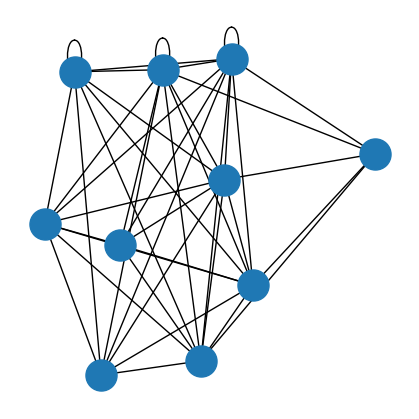

In [3]:
# Step 1: Specify the number of nodes to sample based on the most connections (highest degree)
num_nodes_to_sample = 10  # Set your desired number of nodes

# Get the degrees of all nodes (degree is the number of edges connected to a node)
node_degrees = dict(full_graph.degree())

# Sort nodes by degree in descending order and select the top ones
sampled_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:num_nodes_to_sample]

# Step 2: Create a subgraph from the sampled nodes
G_sampled = full_graph.subgraph(sampled_nodes).copy()

# Step 3: Plot the sampled subgraph with colored edges
plt.figure(figsize=(4, 4))  # Set the plot size
nx.draw(G_sampled, node_size=500)
plt.show()


In [4]:
# Create a list of tuples (node, degree) and sort by degree in descending order
num_nodes_to_sample = 10
sorted_nodes_with_degrees = sorted(node_degrees.items(), key=lambda item: item[1], reverse=True)[:num_nodes_to_sample]

# Display the sorted nodes with their degrees
for node, degree in sorted_nodes_with_degrees:
    print(f"Node: {node}, Degree: {degree}")

Node: br3adman, Degree: 104669
Node: malikimrana1, Degree: 97931
Node: phasuk111, Degree: 93031
Node: sonergonul, Degree: 92079
Node: omarabid, Degree: 84426
Node: xahac, Degree: 77391
Node: nickcodipietro, Degree: 70056
Node: alpb, Degree: 64969
Node: kmorrison, Degree: 60065
Node: kimkardashian, Degree: 59052


In [10]:
# Get the degree of each node (the number of edges connected to each node)
degree_counts = dict(full_graph.degree())

# Prepare a list of degree values
degree_values = list(degree_counts.values())

# Count the frequency of each degree value
degree_distribution = Counter(degree_values)

# Display the number of nodes for each degree (0 edges, 1 edge, 2 edges, etc.)
# for degree, count in sorted(degree_distribution.items()):
    # print(f"Nodes with {degree} edges: {count}")

# Calculate min, max, average, and median of the degree values
min_degree = np.min(degree_values)
max_degree = np.max(degree_values)
average_degree = np.mean(degree_values)
median_degree = np.median(degree_values)

# Count the number of nodes with min and max edges
min_degree_count = degree_distribution[min_degree]
max_degree_count = degree_distribution[max_degree]

# Print statistics
print(f"\nMinimum degree: {min_degree} (Nodes: {min_degree_count})")
print(f"Maximum degree: {max_degree} (Nodes: {max_degree_count})")
print(f"Average degree: {average_degree:.2f}")
print(f"Median degree: {median_degree}")


Minimum degree: 1 (Nodes: 147619)
Maximum degree: 104669 (Nodes: 1)
Average degree: 69.22
Median degree: 6.0


## 3. Analyze Network Structure

Let's examine the basic characteristics of the network, such as degree distributions.

In [ ]:
# Calculate degree distributions
degrees = dict(G.degree())
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Plot degree distribution
plt.figure(figsize=(10, 6))
sns.histplot(list(degrees.values()), bins=30, kde=True)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

## 4. Detect Communities Using the Louvain Method

The Louvain algorithm is a popular method for community detection in large networks. We'll use this method to detect communities and analyze them.

In [ ]:
%%time
# Convert graph to undirected for community detection
G_undirected = G.to_undirected()

# Apply Louvain method for community detection
partition = community_louvain.best_partition(G_undirected)
communities = set(partition.values())
num_communities = len(communities)

print(f"Number of communities detected: {num_communities}")

# Add community information as node attribute
nx.set_node_attributes(G, partition, 'community')

## 5. Visualize Communities

Let's visualize the detected communities. Each node will be colored based on the community it belongs to.

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_undirected, k=0.1)

# Draw nodes with colors according to community
colors = [partition[node] for node in G_undirected.nodes]
nx.draw_networkx_nodes(G_undirected, pos, node_color=colors, cmap=plt.cm.jet, node_size=20)

# Draw edges
nx.draw_networkx_edges(G_undirected, pos, alpha=0.1)

plt.title('Community Detection using Louvain Method')
plt.axis('off')
plt.show()

## 6. Community Analysis

We can further analyze the communities to understand their sizes and characteristics.

In [ ]:
# Calculate size of each community
community_sizes = pd.Series(list(partition.values())).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=community_sizes.index, y=community_sizes.values, palette='viridis')
plt.title('Community Size Distribution')
plt.xlabel('Community ID')
plt.ylabel('Number of Nodes')
plt.show()

## 7. Save the Results

Finally, let's save the graph with community information for further analysis if needed.

In [ ]:
# Save graph with community info
nx.write_gexf(G, 'friendfeed_community_graph.gexf')
print("Graph with community information saved as 'friendfeed_community_graph.gexf'.")